In [1]:
#@title Import libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [6]:
#@title Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
#@title Load data
macro_df = pd.read_csv("/content/drive/MyDrive/macro_features.csv", index_col="Date", parse_dates=True)
macro_df.head()

,CPI,Unemployment,10Y_Treasury,FedFundsRate,IP_Index,GDP_Growth,Inflation,Lending_Rate
Date,,,,,,,,
2010-01-31,217.488,9.8,3.73,0.11,89.1897,4.097918,-0.728243,1.598333
2010-02-28,217.281,9.8,3.69,0.13,89.5046,4.097918,-0.728243,1.598333
2010-03-31,217.353,9.9,3.73,0.16,90.1356,4.097918,-0.728243,1.598333
2010-04-30,217.403,9.9,3.85,0.20,90.4607,4.097918,-0.728243,1.598333
2010-05-31,217.290,9.6,3.42,0.20,91.7014,4.097918,-0.728243,1.598333


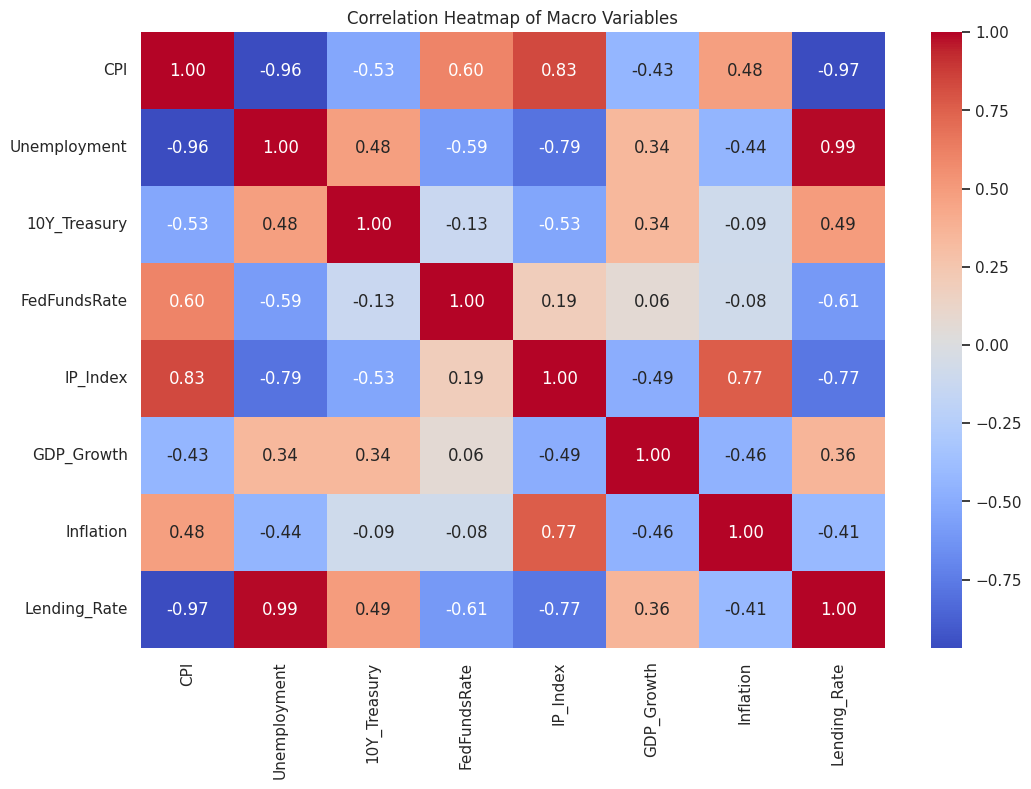

In [18]:
summary = macro_df.describe().T
summary["missing_values"] = macro_df.isnull().sum()
summary["first_valid"] = macro_df.apply(pd.Series.first_valid_index)
summary["last_valid"] = macro_df.apply(pd.Series.last_valid_index)
summary

plt.figure(figsize=(12, 8))
sns.heatmap(macro_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Macro Variables")
plt.show()

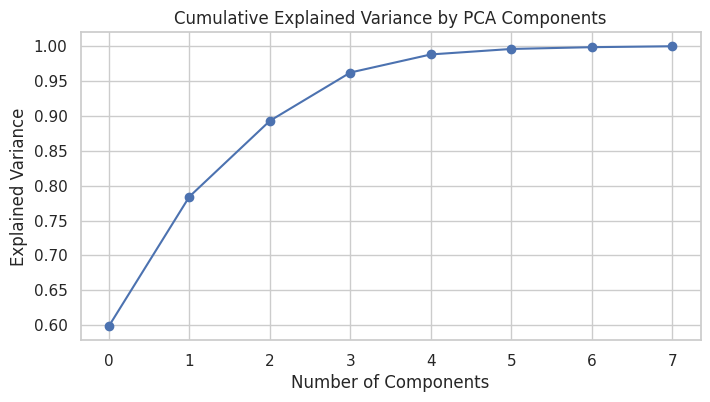

/tmp/ipython-input-19-316534873.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.arrow(0, 0, loadings["PC1"][i]*3, loadings["PC2"][i]*3, color='r', alpha=0.5)
/tmp/ipython-input-19-316534873.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(loadings["PC1"][i]*3.2, loadings["PC2"][i]*3.2, var, color='g', ha='center', va='center')


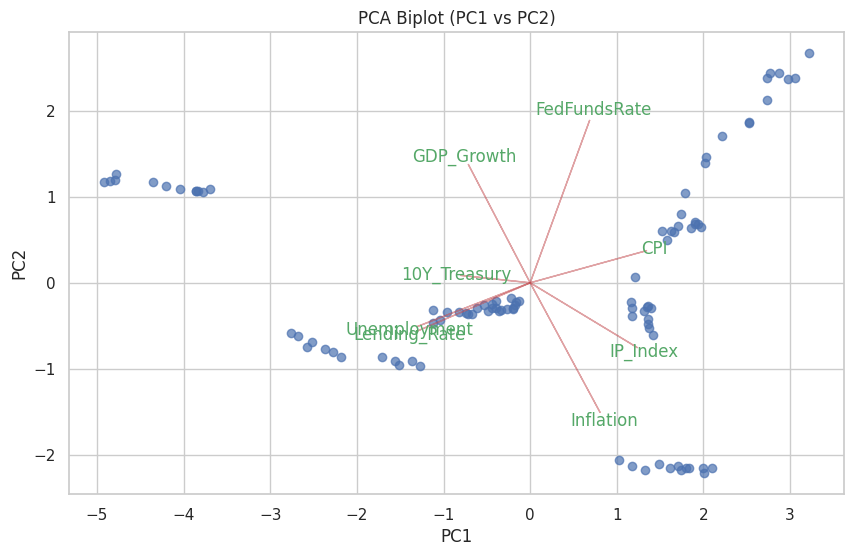

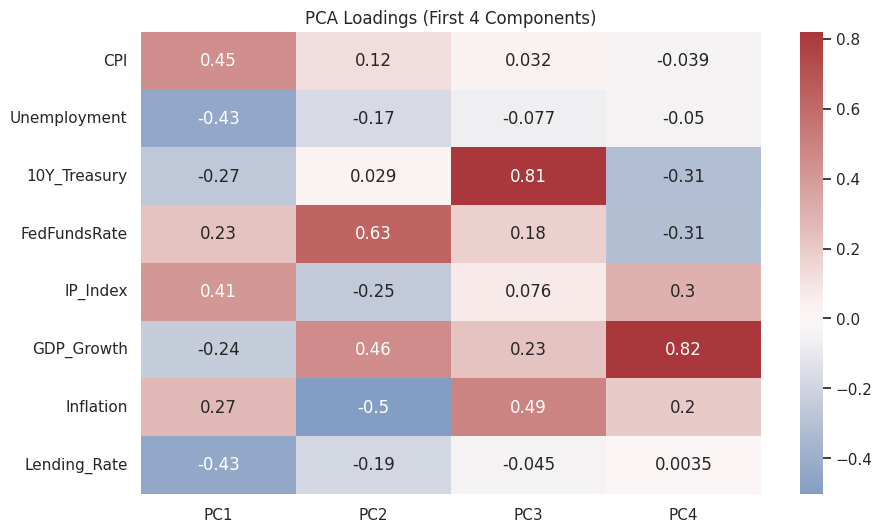

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(macro_df)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, index=macro_df.index, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
loadings = pd.DataFrame(pca.components_.T, index=macro_df.columns, columns=pca_df.columns)

plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(pca_df["PC1"], pca_df["PC2"], alpha=0.7)
for i, var in enumerate(loadings.index):
    plt.arrow(0, 0, loadings["PC1"][i]*3, loadings["PC2"][i]*3, color='r', alpha=0.5)
    plt.text(loadings["PC1"][i]*3.2, loadings["PC2"][i]*3.2, var, color='g', ha='center', va='center')
plt.title("PCA Biplot (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(loadings.iloc[:, :4], annot=True, cmap='vlag', center=0)
plt.title("PCA Loadings (First 4 Components)")
plt.show()

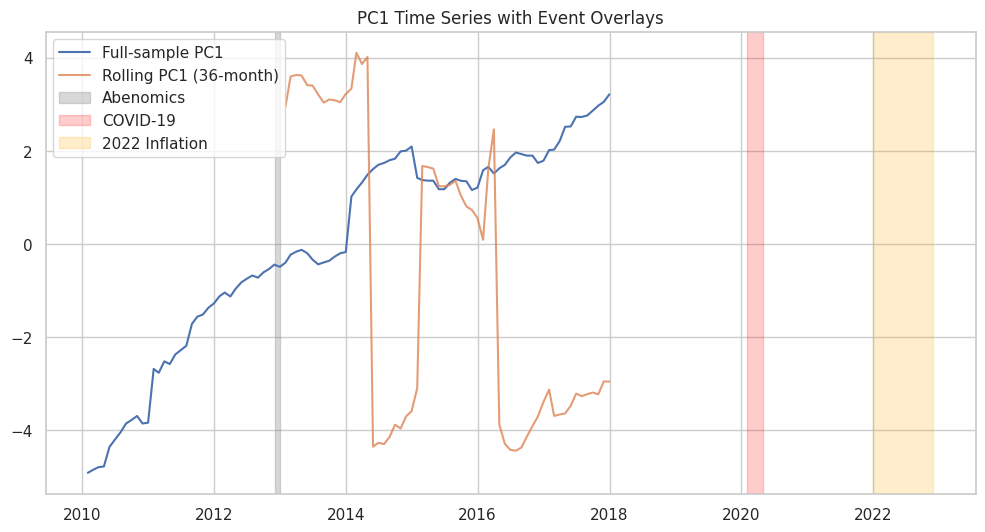

In [20]:
rolling_pca_scores = []
window = 36

for i in range(window, len(macro_df)):
    X_window = scaler.fit_transform(macro_df.iloc[i-window:i])
    pca_window = PCA(n_components=1)
    score = pca_window.fit_transform(X_window)[-1][0]
    rolling_pca_scores.append(score)

rolling_index = macro_df.index[window:]
rolling_pc1 = pd.Series(rolling_pca_scores, index=rolling_index)

plt.figure(figsize=(12, 6))
plt.plot(pca_df["PC1"], label="Full-sample PC1")
plt.plot(rolling_pc1, label="Rolling PC1 (36-month)", alpha=0.8)
plt.axvspan("2012-12", "2013-01", color='gray', alpha=0.3, label="Abenomics")
plt.axvspan("2020-02", "2020-05", color='red', alpha=0.2, label="COVID-19")
plt.axvspan("2022-01", "2022-12", color='orange', alpha=0.2, label="2022 Inflation")
plt.legend()
plt.title("PC1 Time Series with Event Overlays")
plt.grid(True)
plt.show()

ADF: 0.2615689175156648
KPSS: 0.01


/tmp/ipython-input-22-3889362976.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print("KPSS:", kpss(pca_df["PC1"], regression='c')[1])
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


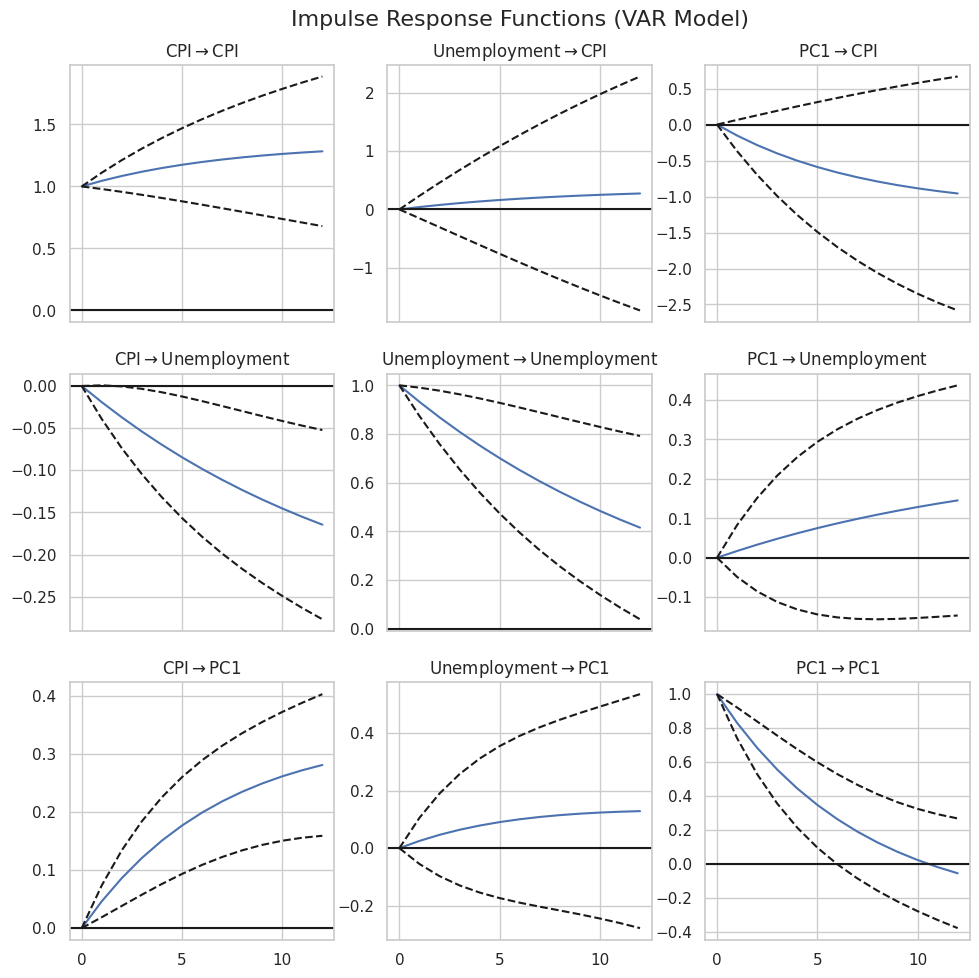

In [22]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

print("ADF:", adfuller(pca_df["PC1"])[1])
print("KPSS:", kpss(pca_df["PC1"], regression='c')[1])

top_vars = loadings["PC1"].abs().sort_values(ascending=False).head(2).index.tolist()
var_df = macro_df[top_vars].copy()
var_df["PC1"] = pca_df["PC1"]
var_df = var_df.dropna()

model = VAR(var_df)
results = model.fit(maxlags=1)
irf = results.irf(12)

irf.plot(orth=False)
plt.suptitle("Impulse Response Functions (VAR Model)", fontsize=16)
plt.show()

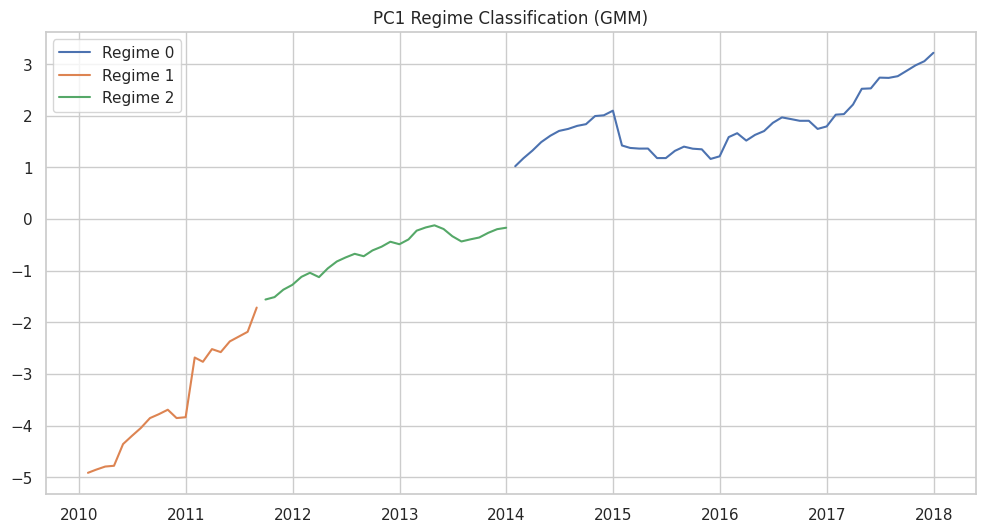

In [23]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0)
regimes = gmm.fit_predict(pca_df[["PC1"]])
pca_df["Regime"] = regimes

plt.figure(figsize=(12, 6))
for r in np.unique(regimes):
    plt.plot(pca_df[pca_df["Regime"] == r].index, pca_df["PC1"][pca_df["Regime"] == r], label=f"Regime {r}")
plt.legend()
plt.title("PC1 Regime Classification (GMM)")
plt.grid(True)
plt.show()

pca_df["PC1"].to_csv("macro_factor.csv")
pca_df["Regime"].to_csv("macro_regime.csv")

In [24]:
#@title Export as CSV

from google.colab import files

files.download("macro_factor.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
files.download("macro_regime.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>